# **Problem 1**

In [ ]:
!pip install nltk pandas scikit-learn transformers gensim tensorflow emoji matplotlib

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [matplotlib]


In [ ]:
import pandas as pd
import re
import string
import string
import emoji
from nltk.tokenize import TweetTokenizer
from transformers import AutoTokenizer

In [ ]:
import re
import numpy as np
import pandas as pd
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from gensim.models import Word2Vec, KeyedVectors
import tensorflow as tf
from tensorflow.keras import layers, models

from transformers import BertTokenizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## **1.1. Data Cleaning and preprocessing**

In [ ]:
file_path = "training.1600000.processed.noemoticon.csv"

df = pd.read_csv(
    file_path,
    encoding="latin-1",
    header=None
)

df.columns = ["sentiment", "id", "date", "query", "user", "text"]

df.head()

,sentiment,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
df['sentiment'] = df['sentiment'].replace({4: 1})
df = df[['sentiment', 'text']]
df.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [ ]:
df['sentiment'].unique()

array([0, 1])

In [ ]:
from nltk.tokenize import TweetTokenizer
from transformers import AutoTokenizer

tweet_tokenizer = TweetTokenizer(
    preserve_case=False,
    reduce_len=True,
    strip_handles=True
)

subword_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def clean_tweet(text):
    if not isinstance(text, str):
        return ""

    # 1. Lowercase
    text = text.lower()

    # 2. Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    # 3. Remove @mentions
    text = re.sub(r'@\w+', '', text)

    # 4. Remove hashtags (keep hashtag word)
    text = text.replace("#", "")

    # 5. Remove punctuation except emojis
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)

    # 6. Convert emojis to text
    text = emoji.demojize(text, delimiters=(" ", " "))

    # 7. Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    # 8. Tokenize
    tokens = tweet_tokenizer.tokenize(text)

    # 9. Handle OOV using WordPiece tokenization
    subword_tokens = []
    for token in tokens:
        pieces = subword_tokenizer.tokenize(token)
        subword_tokens.extend(pieces)

    cleaned_text = " ".join(subword_tokens)
    return cleaned_text


In [ ]:
df_small = df.sample(200000, random_state=42).reset_index(drop=True)
df_small['clean_text'] = df_small['text'].apply(clean_tweet)

In [ ]:
df_preview = df_small[['text', 'clean_text']].head(10).copy()

# Remove ONLY the "##" subword markers for display
df_preview['clean_text'] = df_preview['clean_text'].str.replace("##", "", regex=False)

df_preview


,text,clean_text
0,@chrishasboobs AHHH I HOPE YOUR OK!!!,ah hh i hope your ok
1,"@misstoriblack cool , i have no tweet apps fo...",cool i have no t wee t apps for my ra z r 2
2,@TiannaChaos i know just family drama. its la...,i know just family drama its lame hey next tim...
3,School email won't open and I have geography ...,school email won t open and i have geography s...
4,upper airways problem,upper airways problem
5,Going to miss Pastor's sermon on Faith...,going to miss pastor s sermon on faith
6,on lunch....dj should come eat with me,on lunch d j should come eat with me
7,@piginthepoke oh why are you feeling like that?,oh why are you feeling like that
8,gahh noo!peyton needs to live!this is horrible,ga hh no ope yt on needs to live thi s is horr...
9,@mrstessyman thank you glad you like it! There...,thank you glad you like it there is a product ...


In [ ]:
df_cleaned = df_small[['sentiment', 'clean_text']].copy()

df_cleaned = df_cleaned.dropna(subset=['clean_text'])
df_cleaned = df_cleaned[df_cleaned['clean_text'].str.strip() != ""].reset_index(drop=True)



df_cleaned = df_cleaned.sample(frac=1, random_state=42).reset_index(drop=True)
print(f"Original dataset shape: {df.shape}")
print(f"Cleaned dataset shape: {df_cleaned.shape}")

df_cleaned.head()

Original dataset shape: (1600000, 2)
Cleaned dataset shape: (199574, 2)


,sentiment,clean_text
0,1,really i think they ##re amazing lt ##3
1,0,how ##d it go today i wasn ##t even by the tv ...
2,1,o ##oo ##h k ##k using honey is a lux ##ery se...
3,0,on ze train to limerick hasn ##t left yet the ...
4,0,i don ##t understand


In [ ]:
from sklearn.model_selection import train_test_split

# Step 1: Get 90k training
train_df, temp = train_test_split(
    df_cleaned,
    train_size=180000,
    shuffle=True,
    random_state=42
)

# Step 2: From remaining, get 4k validation + 4k test
val_df, test_df = train_test_split(
    temp,
    train_size=9000,
    test_size=9000,
    shuffle=True,
    random_state=42
)

print("Train ", train_df.shape)
print("Val: ", val_df.shape)
print("Test: ", test_df.shape)

Train  (180000, 2)
Val:  (9000, 2)
Test:  (9000, 2)


## **1.2 Modelling**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Bidirectional, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import gensim
from gensim.models import Word2Vec
import os, re

In [ ]:
# Texts and labels
X_train_text = train_df['clean_text'].astype(str).tolist()
y_train = train_df['sentiment'].values

X_val_text   = val_df['clean_text'].astype(str).tolist()
y_val        = val_df['sentiment'].values

X_test_text  = test_df['clean_text'].astype(str).tolist()
y_test       = test_df['sentiment'].values

### **TD-IDF embedding**

In [ ]:
max_features = 5000

tfidf = TfidfVectorizer(max_features=max_features)

X_train_tfidf = tfidf.fit_transform(X_train_text).toarray()
X_val_tfidf   = tfidf.transform(X_val_text).toarray()
X_test_tfidf  = tfidf.transform(X_test_text).toarray()

print("TF-IDF shapes:", X_train_tfidf.shape, X_val_tfidf.shape, X_test_tfidf.shape)

TF-IDF shapes: (180000, 5000) (9000, 5000) (9000, 5000)


In [ ]:
max_words = 20000    # vocabulary size
max_len   = 40       # max tweet length (can tune)

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_text)

def texts_to_padded(texts):
    seqs = tokenizer.texts_to_sequences(texts)
    return pad_sequences(seqs, maxlen=max_len, padding='post', truncating='post')

X_train_seq = texts_to_padded(X_train_text)
X_val_seq   = texts_to_padded(X_val_text)
X_test_seq  = texts_to_padded(X_test_text)

word_index = tokenizer.word_index
vocab_size = min(max_words, len(word_index) + 1)

print("Vocab size:", vocab_size)
print("Seq shapes:", X_train_seq.shape, X_val_seq.shape, X_test_seq.shape)

Vocab size: 20000
Seq shapes: (180000, 40) (9000, 40) (9000, 40)


### **Word2Vec embedding**

In [ ]:
# Train Word2Vec on training texts (tokenized by simple split)
sentences = [text.split() for text in X_train_text]
w2v_dim = 200

w2v_model = Word2Vec(
    sentences=sentences,
    vector_size=w2v_dim,
    window=5,
    min_count=2,
    workers=4
)

embedding_matrix_w2v = np.random.normal(scale=0.6, size=(vocab_size, w2v_dim))

for word, i in word_index.items():
    if i >= vocab_size:
        continue
    if word in w2v_model.wv:
        embedding_matrix_w2v[i] = w2v_model.wv[word]

print("Word2Vec embedding matrix:", embedding_matrix_w2v.shape)

Word2Vec embedding matrix: (20000, 200)


### **GloVe embedding**

In [ ]:
glove_dim = 200
glove_path = "glove.twitter.27B.200d.txt"

embeddings_index = {}
with open(glove_path, encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

embedding_matrix_glove = np.random.normal(scale=0.6, size=(vocab_size, glove_dim))

for word, i in word_index.items():
    if i >= vocab_size:
        continue
    vector = embeddings_index.get(word)
    if vector is not None:
        embedding_matrix_glove[i] = vector

print("GloVe embedding matrix:", embedding_matrix_glove.shape)

GloVe embedding matrix: (20000, 200)


**Defining helper functions**

In [ ]:
def build_tfidf_model(input_dim, name_suffix=""):
    model = Sequential(name=f"TFIDF_{name_suffix}")
    model.add(Dense(256, activation='relu', input_shape=(input_dim,)))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=3e-4),
        metrics=['accuracy']
    )
    return model

In [ ]:
def build_rnn_model(vocab_size, embedding_dim, embedding_matrix, rnn_type, name_prefix, trainable_emb):
    model = Sequential(name=f"{name_prefix}_{rnn_type}")
    model.add(
        Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            weights=[embedding_matrix],
            input_length=max_len,
            trainable=trainable_emb
        )
    )

    if rnn_type == "LSTM":
        model.add(LSTM(256, return_sequences=True))
        model.add(LSTM(128))
    elif rnn_type == "GRU":
        model.add(GRU(128))
    elif rnn_type == "BiLSTM":
        model.add(Bidirectional(LSTM(256, return_sequences=True)))
        model.add(Bidirectional(LSTM(128)))
    else:
        raise ValueError("rnn_type must be 'LSTM', 'GRU', or 'BiLSTM'")

    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        loss='binary_crossentropy',
        optimizer = Adam(learning_rate=3e-4),
        metrics=['accuracy']
    )
    return model

In [ ]:
def train_and_debug(model, X_train, y_train, X_val, y_val, X_test, y_test, model_name, epochs, batch_size=64):
    print(f"\n================= Training {model_name} =================\n")
    print(model.summary())

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        verbose=1
    )

    # ---- PLOTS ----
    plt.figure()
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # ---- EVALUATION ON TEST SET ----
    print(f"\n[DEBUG] Evaluating {model_name} on TEST set...")
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
    print(f"[RESULT] Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

    y_pred_prob = model.predict(X_test).ravel()
    y_pred = (y_pred_prob >= 0.45).astype(int)

    precision = precision_score(y_test, y_pred)
    recall    = recall_score(y_test, y_pred)
    f1        = f1_score(y_test, y_pred)

    print(f"[METRICS] {model_name} → Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

    return {
        "model_name": model_name,
        "test_loss": test_loss,
        "test_acc": test_acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }


In [ ]:
results = []

### **----Training-----**


================= Training TFIDF_LSTM =================

Model: "TFIDF_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 256)               1280256   
                                                                 
 dropout_15 (Dropout)        (None, 256)               0         
                                                                 
 dense_19 (Dense)            (None, 64)                16448     
                                                                 
 dropout_16 (Dropout)        (None, 64)                0         
                                                                 
 dense_20 (Dense)            (None, 1)                 65        
                                                                 
Total params: 1296769 (4.95 MB)
Trainable params: 1296769 (4.95 MB)
Non-trainable params: 0 (0.00 Byte)
__________________________

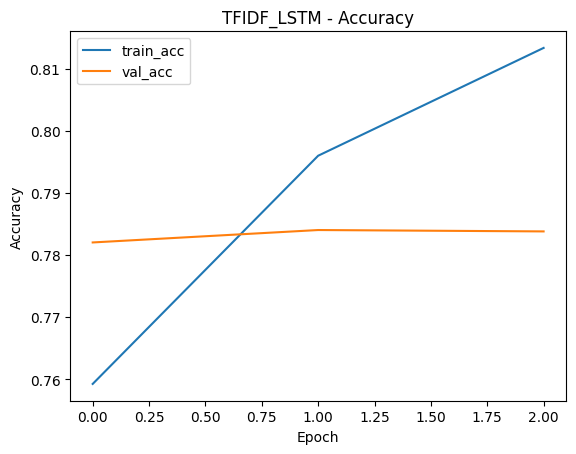

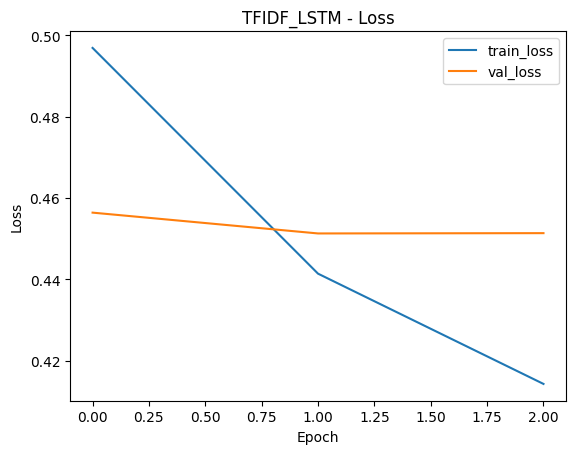


[DEBUG] Evaluating TFIDF_LSTM on TEST set...
282/282 [==============================] - 1s 2ms/step - loss: 0.4569 - accuracy: 0.7854
[RESULT] Test Loss: 0.4569, Test Accuracy: 0.7854
282/282 [==============================] - 0s 1ms/step
[METRICS] TFIDF_LSTM → Precision: 0.7762, Recall: 0.8034, F1: 0.7896

================= Training TFIDF_GRU =================

Model: "TFIDF_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 256)               1280256   
                                                                 
 dropout_17 (Dropout)        (None, 256)               0         
                                                                 
 dense_22 (Dense)            (None, 64)                16448     
                                                                 
 dropout_18 (Dropout)        (None, 64)                0         
                     

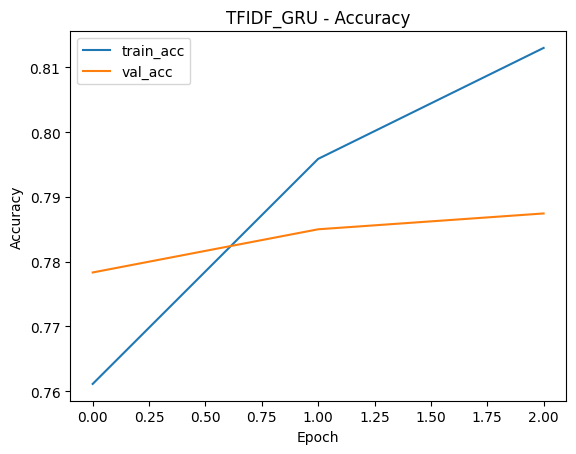

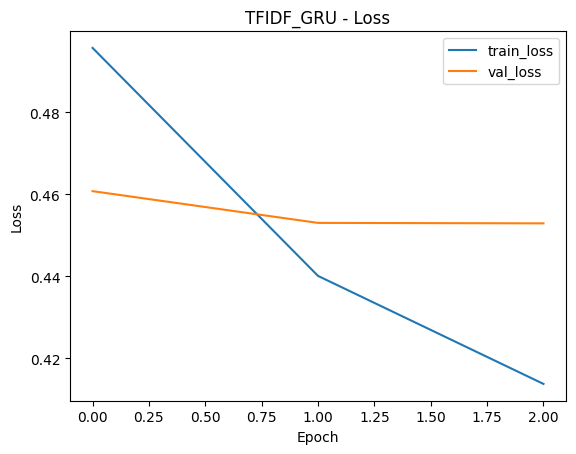


[DEBUG] Evaluating TFIDF_GRU on TEST set...
282/282 [==============================] - 1s 2ms/step - loss: 0.4592 - accuracy: 0.7866
[RESULT] Test Loss: 0.4592, Test Accuracy: 0.7866
282/282 [==============================] - 0s 1ms/step
[METRICS] TFIDF_GRU → Precision: 0.7720, Recall: 0.8057, F1: 0.7885

================= Training TFIDF_BiLSTM =================

Model: "TFIDF_BiLSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 256)               1280256   
                                                                 
 dropout_19 (Dropout)        (None, 256)               0         
                                                                 
 dense_25 (Dense)            (None, 64)                16448     
                                                                 
 dropout_20 (Dropout)        (None, 64)                0         
                 

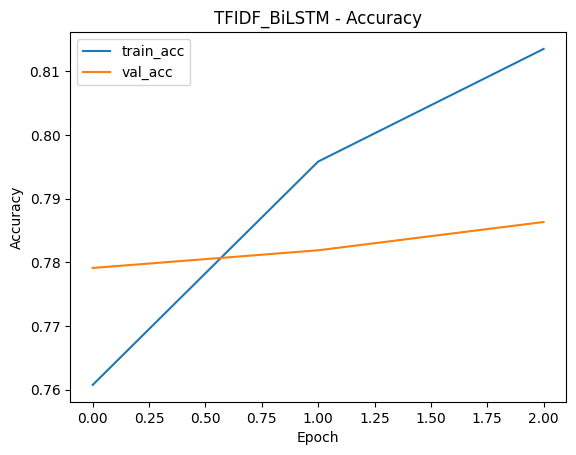

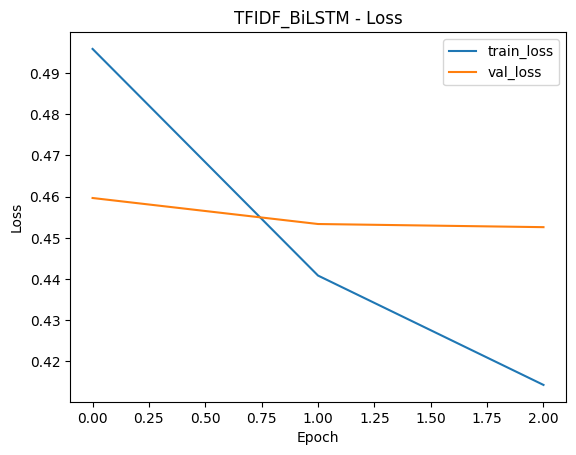


[DEBUG] Evaluating TFIDF_BiLSTM on TEST set...
282/282 [==============================] - 1s 3ms/step - loss: 0.4578 - accuracy: 0.7867
[RESULT] Test Loss: 0.4578, Test Accuracy: 0.7867
282/282 [==============================] - 0s 1ms/step
[METRICS] TFIDF_BiLSTM → Precision: 0.7789, Recall: 0.8039, F1: 0.7912


In [ ]:
input_dim_tfidf = X_train_tfidf.shape[1]

for suffix in ["LSTM", "GRU", "BiLSTM"]:
    model_tfidf = build_tfidf_model(input_dim=input_dim_tfidf, name_suffix=suffix)
    res = train_and_debug(
        model_tfidf,
        X_train_tfidf, y_train,
        X_val_tfidf, y_val,
        X_test_tfidf, y_test,
        model_name=f"TFIDF_{suffix}",
        epochs=3
    )
    results.append(res)



================= Training W2V_LSTM =================

Model: "W2V_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 40, 200)           4000000   
                                                                 
 lstm_6 (LSTM)               (None, 40, 256)           467968    
                                                                 
 lstm_7 (LSTM)               (None, 128)               197120    
                                                                 
 dropout_12 (Dropout)        (None, 128)               0         
                                                                 
 dense_15 (Dense)            (None, 1)                 129       
                                                                 
Total params: 4665217 (17.80 MB)
Trainable params: 4665217 (17.80 MB)
Non-trainable params: 0 (0.00 Byte)
____________________________

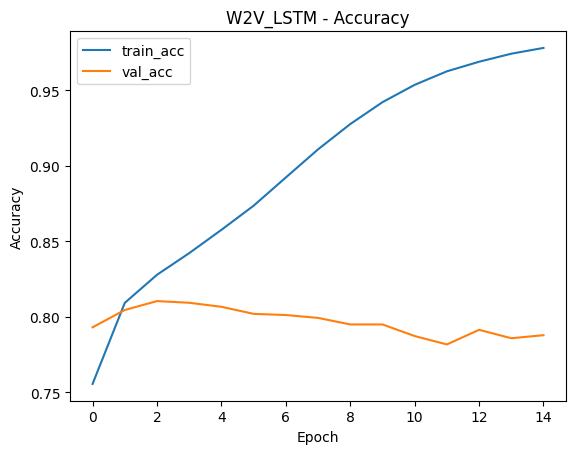

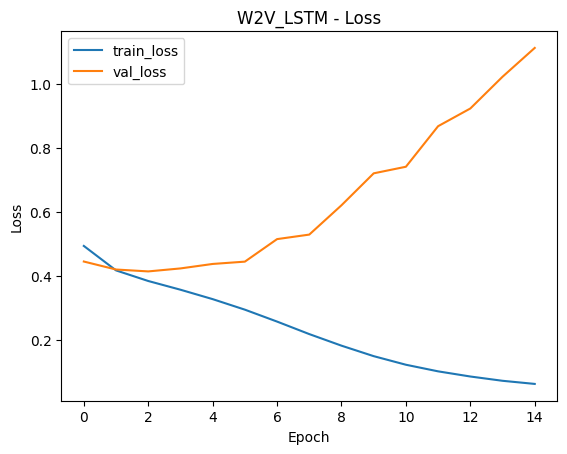


[DEBUG] Evaluating W2V_LSTM on TEST set...
282/282 [==============================] - 3s 12ms/step - loss: 1.1153 - accuracy: 0.7843
[RESULT] Test Loss: 1.1153, Test Accuracy: 0.7843
282/282 [==============================] - 3s 10ms/step
[METRICS] W2V_LSTM → Precision: 0.7905, Recall: 0.7732, F1: 0.7817

================= Training W2V_GRU =================

Model: "W2V_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 40, 200)           4000000   
                                                                 
 gru_2 (GRU)                 (None, 128)               126720    
                                                                 
 dropout_13 (Dropout)        (None, 128)               0         
                                                                 
 dense_16 (Dense)            (None, 1)                 129       
                           

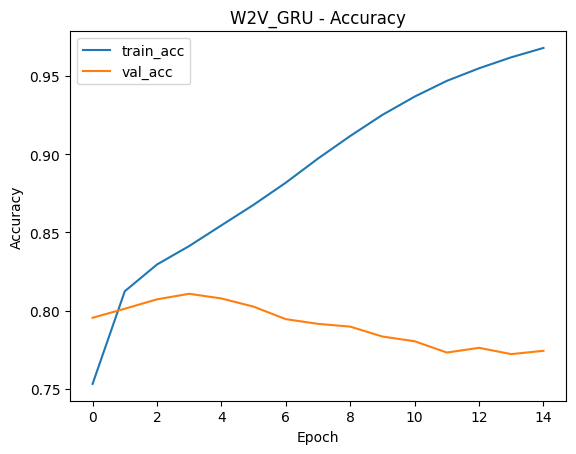

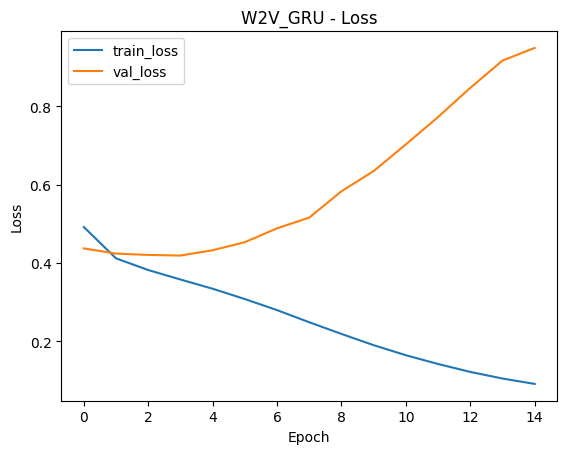


[DEBUG] Evaluating W2V_GRU on TEST set...
282/282 [==============================] - 1s 5ms/step - loss: 0.9392 - accuracy: 0.7742
[RESULT] Test Loss: 0.9392, Test Accuracy: 0.7742
282/282 [==============================] - 1s 3ms/step
[METRICS] W2V_GRU → Precision: 0.7765, Recall: 0.7705, F1: 0.7735

================= Training W2V_BiLSTM =================

Model: "W2V_BiLSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 40, 200)           4000000   
                                                                 
 bidirectional_4 (Bidirecti  (None, 40, 512)           935936    
 onal)                                                           
                                                                 
 bidirectional_5 (Bidirecti  (None, 256)               656384    
 onal)                                                           
                         

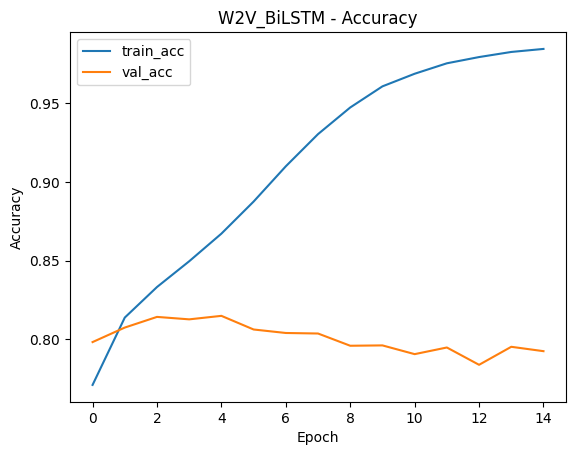

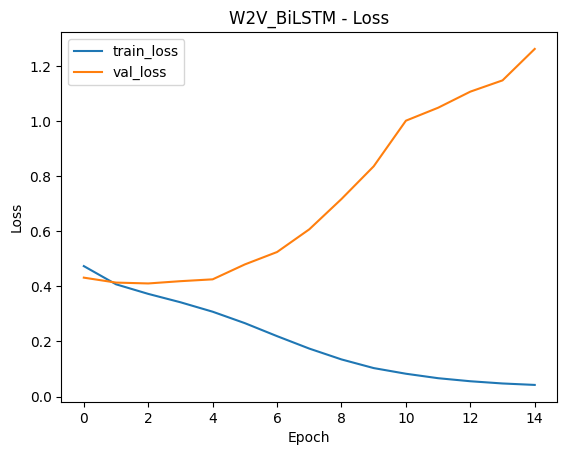


[DEBUG] Evaluating W2V_BiLSTM on TEST set...
282/282 [==============================] - 15s 53ms/step - loss: 1.3244 - accuracy: 0.7842
[RESULT] Test Loss: 1.3244, Test Accuracy: 0.7842
282/282 [==============================] - 16s 54ms/step
[METRICS] W2V_BiLSTM → Precision: 0.7900, Recall: 0.7785, F1: 0.7842


In [ ]:
for rnn_type in ["LSTM", "GRU", "BiLSTM"]:
    model_w2v = build_rnn_model(
        vocab_size=vocab_size,
        embedding_dim=w2v_dim,
        embedding_matrix=embedding_matrix_w2v,
        rnn_type=rnn_type,
        name_prefix="W2V",
        trainable_emb=True  # you can try True later
    )

    res = train_and_debug(
        model_w2v,
        X_train_seq, y_train,
        X_val_seq, y_val,
        X_test_seq, y_test,
        model_name=f"W2V_{rnn_type}",
        epochs=15
    )
    results.append(res)



================= Training GLOVE_LSTM =================

Model: "GLOVE_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 40, 200)           4000000   
                                                                 
 lstm_10 (LSTM)              (None, 40, 256)           467968    
                                                                 
 lstm_11 (LSTM)              (None, 128)               197120    
                                                                 
 dropout_21 (Dropout)        (None, 128)               0         
                                                                 
 dense_27 (Dense)            (None, 1)                 129       
                                                                 
Total params: 4665217 (17.80 MB)
Trainable params: 4665217 (17.80 MB)
Non-trainable params: 0 (0.00 Byte)
________________________

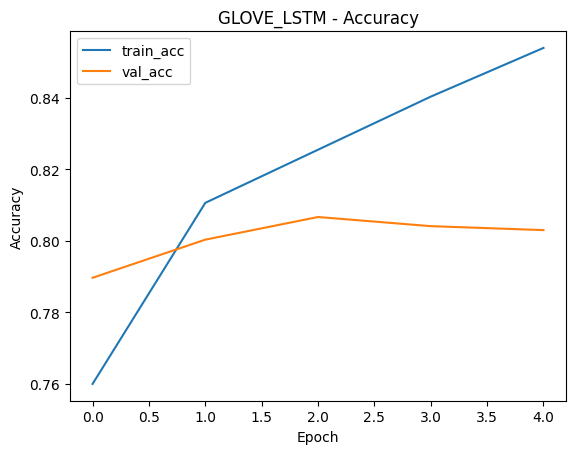

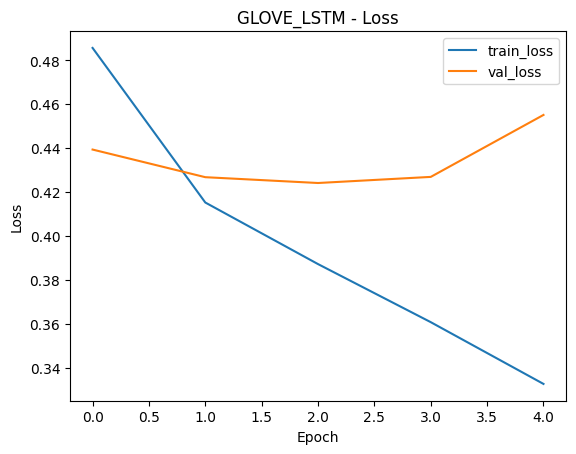


[DEBUG] Evaluating GLOVE_LSTM on TEST set...
282/282 [==============================] - 5s 17ms/step - loss: 0.4587 - accuracy: 0.8047
[RESULT] Test Loss: 0.4587, Test Accuracy: 0.8047
282/282 [==============================] - 4s 14ms/step
[METRICS] GLOVE_LSTM → Precision: 0.8049, Recall: 0.8119, F1: 0.8084

================= Training GLOVE_GRU =================

Model: "GLOVE_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 40, 200)           4000000   
                                                                 
 gru_3 (GRU)                 (None, 128)               126720    
                                                                 
 dropout_22 (Dropout)        (None, 128)               0         
                                                                 
 dense_28 (Dense)            (None, 1)                 129       
                   

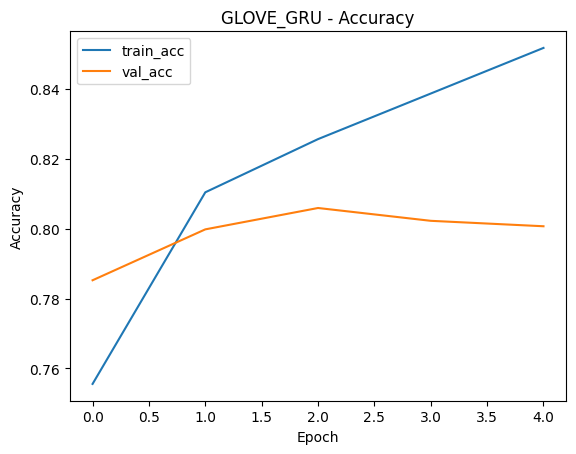

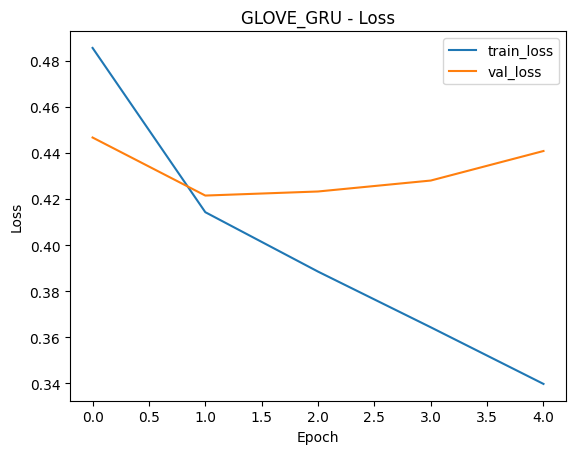


[DEBUG] Evaluating GLOVE_GRU on TEST set...
282/282 [==============================] - 1s 4ms/step - loss: 0.4409 - accuracy: 0.8051
[RESULT] Test Loss: 0.4409, Test Accuracy: 0.8051
282/282 [==============================] - 1s 4ms/step
[METRICS] GLOVE_GRU → Precision: 0.7884, Recall: 0.8326, F1: 0.8099

================= Training GLOVE_BiLSTM =================

Model: "GLOVE_BiLSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 40, 200)           4000000   
                                                                 
 bidirectional_6 (Bidirecti  (None, 40, 512)           935936    
 onal)                                                           
                                                                 
 bidirectional_7 (Bidirecti  (None, 256)               656384    
 onal)                                                           
                 

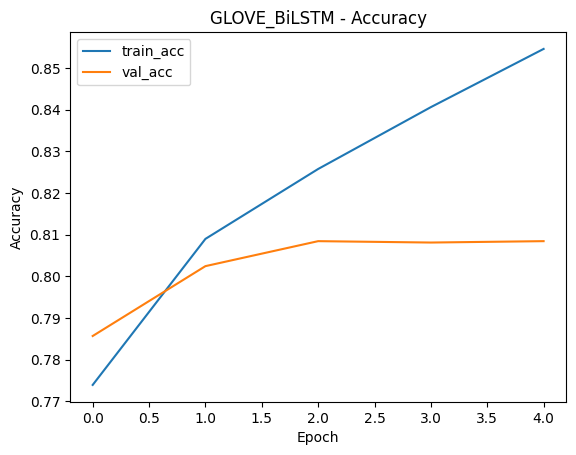

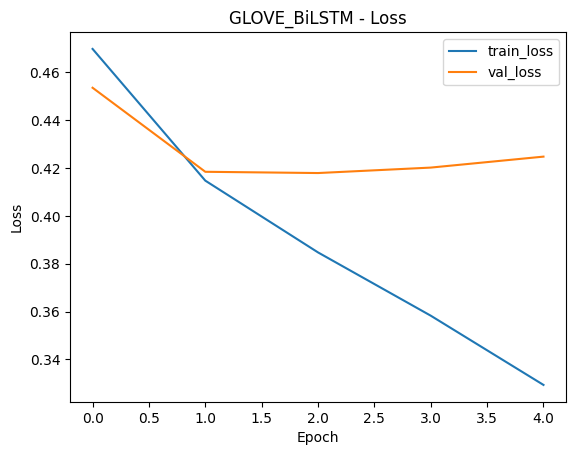


[DEBUG] Evaluating GLOVE_BiLSTM on TEST set...
282/282 [==============================] - 7s 24ms/step - loss: 0.4329 - accuracy: 0.8023
[RESULT] Test Loss: 0.4329, Test Accuracy: 0.8023
282/282 [==============================] - 7s 23ms/step
[METRICS] GLOVE_BiLSTM → Precision: 0.8042, Recall: 0.8090, F1: 0.8066


In [ ]:
for rnn_type in ["LSTM", "GRU", "BiLSTM"]:
    model_glove = build_rnn_model(
        vocab_size=vocab_size,
        embedding_dim=glove_dim,
        embedding_matrix=embedding_matrix_glove,
        rnn_type=rnn_type,
        name_prefix="GLOVE",
        trainable_emb=True  # try True later for fine-tuning
    )

    res = train_and_debug(
        model_glove,
        X_train_seq, y_train,
        X_val_seq, y_val,
        X_test_seq, y_test,
        model_name=f"GLOVE_{rnn_type}",
        epochs=5
    )
    results.append(res)


In [ ]:
model_glove_lstm = build_rnn_model(
    vocab_size=vocab_size,
    embedding_dim=glove_dim,
    embedding_matrix=embedding_matrix_glove,
    rnn_type="LSTM",
    name_prefix="GLOVE",
    trainable_emb=True
)

res_glove_lstm = train_and_debug(
    model_glove_lstm,
    X_train_seq, y_train,
    X_val_seq, y_val,
    X_test_seq, y_test,
    model_name="GLOVE_LSTM",
    epochs=5
)

In [ ]:
results_df = pd.DataFrame(results)
results_df

,model_name,test_loss,test_acc,precision,recall,f1
0,W2V_LSTM,1.115342,0.784333,0.790461,0.773159,0.781715
1,W2V_GRU,0.939236,0.774222,0.776515,0.770506,0.773499
2,W2V_BiLSTM,1.324443,0.784222,0.789993,0.778466,0.784187
3,TFIDF_LSTM,0.456903,0.785444,0.776164,0.803449,0.789571
4,TFIDF_GRU,0.459236,0.786556,0.772034,0.805660,0.788489
5,TFIDF_BiLSTM,0.457811,0.786667,0.778920,0.803891,0.791209
6,GLOVE_LSTM,0.458733,0.804667,0.804910,0.811851,0.808365
7,GLOVE_GRU,0.440874,0.805111,0.788361,0.832633,0.809892
8,GLOVE_BiLSTM,0.432909,0.802333,0.804176,0.808976,0.806569


In [ ]:

import numpy as np
import random
import re
from sklearn.metrics import f1_score

best_model = model_glove


test_probs = best_model.predict(X_test_seq).ravel()
test_preds = (test_probs >= 0.5).astype(int)
test_true  = y_test


misclassified = []
for text, true, pred in zip(test_df["clean_text"], test_true, test_preds):
    if true != pred:
        misclassified.append((text, true, pred))

print("Total misclassified tweets:", len(misclassified))


random.seed(42)
sample_errors = random.sample(misclassified, 50)


def is_sarcasm(text):
    sarcasm_keywords = ["yeah right", "sure", "totally", "as if", "great...", "love that for me"]
    return any(kw in text.lower() for kw in sarcasm_keywords)

def is_negation_error(text):
    neg = ["not", "never", "no", "don't", "isn't", "wasn't"]
    pos = ["good", "great", "happy", "love", "fun", "amazing"]
    return any(n in text.lower().split() for n in neg) and any(p in text.lower() for p in pos)

def is_oov_slang(text):
    slang = ["lol", "lmao", "omg", "smh", "fr", "idk", "tbh", "ikr", "bruh"]
    emojis = re.findall(r'[^\w\s,.:;!?]', text)
    return any(s in text.lower() for s in slang) or len(emojis) >= 2

def is_multi_topic(text):
    pos = ["happy", "love", "good", "great"]
    neg = ["sad", "bad", "angry", "hate", "upset"]
    return any(p in text.lower() for p in pos) and any(n in text.lower() for n in neg)

def is_domain_drift(text):
    drift = ["election", "politics", "trump", "nfl", "stock", "crypto", "covid", "vaccine"]
    return any(d in text.lower() for d in drift)

categories = {
    "sarcasm": [],
    "negation": [],
    "oov_slang": [],
    "multi_topic": [],
    "domain_drift": []
}

for text, true, pred in sample_errors:
    if is_sarcasm(text):
        categories["sarcasm"].append((text, true, pred))
    elif is_negation_error(text):
        categories["negation"].append((text, true, pred))
    elif is_oov_slang(text):
        categories["oov_slang"].append((text, true, pred))
    elif is_multi_topic(text):
        categories["multi_topic"].append((text, true, pred))
    elif is_domain_drift(text):
        categories["domain_drift"].append((text, true, pred))


for cat, items in categories.items():
    print(f"\n========== {cat.upper()} ==========")
    if len(items) == 0:
        print("No items found.")
        continue
    for t in items[:2]:
        print("Tweet:", t[0])
        print("True Label:", t[1], "Predicted:", t[2])
        print()


282/282 [==============================] - 16s 56ms/step
Total misclassified tweets: 1779

========== SARCASM ==========
Tweet: they sure ##e did and they did show up and play my nu ##ggs didn ##t unfortunately but hey im still a fan ps go magic
True Label: 0 Predicted: 1


========== NEGATION ==========
Tweet: hey ralph i never got this one from you can you send over love your track g ##fa ##b 01 ##1
True Label: 1 Predicted: 0


========== OOV_SLANG ==========
Tweet: yet its you i see wasting the dream that only i deserve ill tear off your face to see your smile lt ##3
True Label: 1 Predicted: 0

Tweet: morning quick he ##lo ##oo ##wil ##l be out of wi ##fi range in deepest darkest liverpool for next 24 hr ##s amp don ##t have technology to t ##wee ##t other ##ways
True Label: 0 Predicted: 1


========== MULTI_TOPIC ==========
Tweet: i love that you hate physics and biology right now science is a shit ole
True Label: 1 Predicted: 0


========== DOMAIN_DRIFT ==========
No items found.


## **BONUS**

In [ ]:
pip install tf-keras

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 13.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [ ]:
!pip install -q transformers datasets accelerate sentencepiece

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
import numpy as np
import torch
from torch.utils.data import DataLoader
from datasets import Dataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup


train_ds = Dataset.from_pandas(train_df[['clean_text','sentiment']])
val_ds   = Dataset.from_pandas(val_df[['clean_text','sentiment']])
test_ds  = Dataset.from_pandas(test_df[['clean_text','sentiment']])


model_name = "vinai/bertweet-large"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False)

def tokenize(batch):
    return tokenizer(
        batch["clean_text"],
        padding="max_length",
        truncation=True,
        max_length=128
    )

train_ds = train_ds.map(tokenize, batched=True)
val_ds   = val_ds.map(tokenize, batched=True)
test_ds  = test_ds.map(tokenize, batched=True)

train_ds = train_ds.rename_column("sentiment","labels")
val_ds   = val_ds.rename_column("sentiment","labels")
test_ds  = test_ds.rename_column("sentiment","labels")

train_ds.set_format("torch")
val_ds.set_format("torch")
test_ds.set_format("torch")


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

batch_size = 16

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32)
test_loader  = DataLoader(test_ds, batch_size=32)


model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2
)
model.to(device)


for param in model.roberta.embeddings.parameters():
    param.requires_grad = False

for layer in model.roberta.encoder.layer[:12]:  # freeze first 12 of 24 layers
    for param in layer.parameters():
        param.requires_grad = False


epochs = 3
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

num_training_steps = len(train_loader) * epochs
num_warmup_steps = int(0.1 * num_training_steps)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps
)

def train_one_epoch(model, dataloader, optimizer, scheduler, epoch):
    model.train()
    total_loss = 0.0

    for batch in dataloader:
        optimizer.zero_grad()

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        loss.backward()

        # Gradient clipping (critical!)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)

        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)


def evaluate(model, dataloader):
    model.eval()
    labels_all, preds_all = [], []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].cpu().numpy()

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = np.argmax(outputs.logits.cpu().numpy(), axis=1)

            labels_all.extend(labels)
            preds_all.extend(preds)

    acc = accuracy_score(labels_all, preds_all)
    prec = precision_score(labels_all, preds_all)
    rec = recall_score(labels_all, preds_all)
    f1 = f1_score(labels_all, preds_all)
    return acc, prec, rec, f1



for epoch in range(epochs):

    train_loss = train_one_epoch(model, train_loader, optimizer, scheduler, epoch)


    if epoch == 0:
        print("\n>>> Unfreezing ALL layers + lowering LR for fine-tuning...\n")

        for param in model.parameters():
            param.requires_grad = True

        # Lower LR for stability
        for g in optimizer.param_groups:
            g["lr"] = 5e-6

    # Evaluation
    val_acc, val_prec, val_rec, val_f1 = evaluate(model, val_loader)

    print(f"\nEpoch {epoch+1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Acc:  {val_acc:.4f}")
    print(f"Val Prec: {val_prec:.4f}")
    print(f"Val Rec:  {val_rec:.4f}")
    print(f"Val F1:   {val_f1:.4f}")



test_acc, test_prec, test_rec, test_f1 = evaluate(model, test_loader)

print("\n========== FINAL TEST RESULTS (BERTweet-Large) ==========")
print(f"Test Acc:  {test_acc:.4f}")
print(f"Test Prec: {test_prec:.4f}")
print(f"Test Rec:  {test_rec:.4f}")
print(f"Test F1:   {test_f1:.4f}")


Map: 100%|██████████| 9000/9000 [00:00<00:00, 12114.04 examples/s]


Using device: cuda


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



>>> Unfreezing ALL layers + lowering LR for fine-tuning...


Epoch 1/3
Train Loss: 0.3928
Val Acc:  0.8578
Val Prec: 0.8852
Val Rec:  0.8148
Val F1:   0.8486

Epoch 2/3
Train Loss: 0.3047
Val Acc:  0.8712
Val Prec: 0.8740
Val Rec:  0.8607
Val F1:   0.8673

Epoch 3/3
Train Loss: 0.2336
Val Acc:  0.8719
Val Prec: 0.8768
Val Rec:  0.8587
Val F1:   0.8676

========== FINAL TEST RESULTS (BERTweet-Large) ==========
Test Acc:  0.8703
Test Prec: 0.8781
Test Rec:  0.8616
Test F1:   0.8698


# **Problem 2**

In [ ]:
import re
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize

from gensim.models import Word2Vec

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, SimpleRNN, LSTM, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
import requests
from bs4 import BeautifulSoup
import re

url = "https://www.gutenberg.org/files/2701/2701-h/2701-h.htm"
html = requests.get(url).text
soup = BeautifulSoup(html, "html.parser")

chapters = []
current_chapter = None
collect = False

for tag in soup.find_all(["h2", "p"]):

    if tag.name == "h2" and tag.get_text(strip=True).startswith("CHAPTER"):

        if current_chapter:
            chapters.append("\n".join(current_chapter))

        current_chapter = []
        collect = True
        continue

    if collect and tag.name == "p":
        text = tag.get_text(" ", strip=True)
        if text:
            current_chapter.append(text)

if current_chapter:
    chapters.append("\n".join(current_chapter))


clean_60 = "\n\n".join(chapters[:60])

with open("moby_dick_60chapters_clean.txt", "w", encoding="utf-8") as f:
    f.write(clean_60)

print("SUCCESS: Extracted real Chapters 1–60")

SUCCESS: Extracted real Chapters 1–60


In [ ]:
print(chapters[60][:500])   # first 500 characters of Chapter 1

If to Starbuck the apparition of the Squid was a thing of portents, to
      Queequeg it was quite a different object.
“When you see him ’quid,” said the savage, honing his harpoon in the bow
      of his hoisted boat, “then you quick see him ’parm whale.”
The next day was exceedingly still and sultry, and with nothing special to
      engage them, the Pequod’s crew could hardly resist the spell of sleep
      induced by such a vacant sea. For this part of the Indian Ocean through
      which we


### **2.1 Preprocessing**

In [ ]:
lemmatizer = WordNetLemmatizer()
# stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Lowercase
    text = text.lower()

    # Expand contractions
    contractions = {
        "can't": "cannot", "won't": "will not", "n't": " not",
        "'re": " are", "'s": " is", "'d": " would",
        "'ll": " will", "'t": " not", "'ve": " have", "'m": " am"
    }
    for c, e in contractions.items():
        text = text.replace(c, e)

    # Remove URLs, numbers, references
    text = re.sub(r"http\S+|www\S+|@\w+|#\w+|\d+", " ", text)

    # Remove punctuation
    text = re.sub(r"[^a-z\s]", " ", text)

    # Tokenize
    tokens = word_tokenize(text)

    # Keep alphabetic only + remove stopwords + lemmatize
    clean_tokens = [
        lemmatizer.lemmatize(w)
        for w in tokens
        if w.isalpha()
    ]

    # Rejoin
    return " ".join(clean_tokens)


In [ ]:
with open("moby_dick_60chapters_clean.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

In [ ]:
sentences = sent_tokenize(raw_text)[:10]
cleaned_examples = [clean_text(s) for s in sentences]

pd.DataFrame({"Original": sentences, "Cleaned": cleaned_examples})

,Original,Cleaned
0,Call me Ishmael.,call me ishmael
1,Some years ago—never mind how long precisely—h...,some year ago never mind how long precisely ha...
2,It is a way I have of driving off the spleen a...,it is a way i have of driving off the spleen a...
3,Whenever I find myself growing grim about the ...,whenever i find myself growing grim about the ...
4,This is my substitute for pistol and ball.,this is my substitute for pistol and ball
5,With a philosophical\n flourish Cato thro...,with a philosophical flourish cato throw himse...
6,There is nothing surprising in this.,there is nothing surprising in this
7,"If they but knew it, almost all men\n in ...",if they but knew it almost all men in their de...
8,There now is your insular city of the Manhatto...,there now is your insular city of the manhatto...
9,"Right and left, the streets take you waterward.",right and left the street take you waterward


In [ ]:
cleaned_text = clean_text(raw_text)

tokenizer = Tokenizer(num_words=8000)
tokenizer.fit_on_texts([cleaned_text])

encoded = tokenizer.texts_to_sequences([cleaned_text])[0]

vocab_size = len(tokenizer.word_index) + 1
print("Tokens:", len(cleaned_text.split()))
print("Unique words:", len(tokenizer.word_index))
print("Max token index:", max(encoded))
print("Vocab size:", len(tokenizer.word_index) + 1)



sequence_length = 30
sequences = []

for i in range(sequence_length, len(encoded)):
    seq = encoded[i-sequence_length:i+1]
    sequences.append(seq)

sequences = np.array(sequences)

X = sequences[:, :-1]
y = to_categorical(sequences[:, -1], num_classes=vocab_size)

X = pad_sequences(X, maxlen=sequence_length)

Tokens: 106118
Unique words: 10501
Max token index: 7999
Vocab size: 10502


### **2.2 Building Three Models**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, SimpleRNN, Bidirectional, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def build_simple_rnn(vocab_size, sequence_length, embedding_dim=200, units=256):
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=sequence_length))
    model.add(SimpleRNN(units))
    model.add(Dense(vocab_size, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

def build_gru(vocab_size, sequence_length, embedding_dim=200, units=256):
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=sequence_length))
    model.add(GRU(units))   # NO recurrent_dropout
    model.add(Dense(vocab_size, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

def build_lstm(vocab_size, sequence_length, embedding_dim=200, units=256):
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=sequence_length))
    model.add(LSTM(units))  # NO recurrent_dropout
    model.add(Dense(vocab_size, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

def build_bilstm(vocab_size, sequence_length, embedding_dim=200, units=256):
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=sequence_length))
    model.add(Bidirectional(LSTM(units)))  # NO recurrent_dropout
    model.add(Dense(vocab_size, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model


**Simple RNN**

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, 30, 200)           2100400   
                                                                 
 simple_rnn_6 (SimpleRNN)    (None, 256)               116992    
                                                                 
 dense_16 (Dense)            (None, 10502)             2699014   
                                                                 
Total params: 4916406 (18.75 MB)
Trainable params: 4916406 (18.75 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
1457/1457 [==============================] - 73s 49ms/step - loss: 6.9556 - accuracy: 0.0659 - val_loss: 6.5251 - val_accuracy: 0.1010
Epoch 2/5
1457/1457 [==============================] - 66s 45ms/step - loss: 6.4508 - accuracy: 0.0853 - val_loss: 6.3287 - val_accu

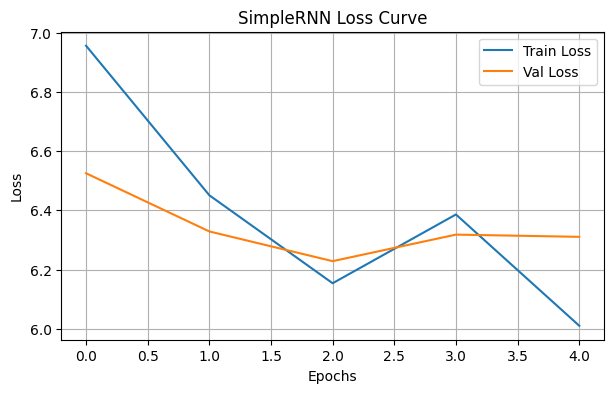

In [ ]:
simple_rnn = build_simple_rnn(vocab_size, sequence_length)
history_simple_rnn = simple_rnn.fit(
    X, y,
    validation_split=0.1,
    epochs=5,
    batch_size=64,
    verbose=1
)

train_loss = history_simple_rnn.history["loss"][-1]
val_loss = history_simple_rnn.history["val_loss"][-1]
perplexity = np.exp(val_loss)
train_acc = history_simple_rnn.history["accuracy"][-1]
val_acc = history_simple_rnn.history["val_accuracy"][-1]

print("\n===== SimpleRNN METRICS =====")
print(f"Train Loss: {train_loss:.4f}")
print(f"Val Loss: {val_loss:.4f}")
print(f"Perplexity: {perplexity:.4f}")
print(f"Train Accuracy: {train_acc:.4f}")
print(f"Val Accuracy: {val_acc:.4f}")

# Loss Curve
plt.figure(figsize=(7,4))
plt.plot(history_simple_rnn.history["loss"], label="Train Loss")
plt.plot(history_simple_rnn.history["val_loss"], label="Val Loss")
plt.title("SimpleRNN Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

**GRU**

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_17 (Embedding)    (None, 30, 200)           2100400   
                                                                 
 gru_6 (GRU)                 (None, 256)               351744    
                                                                 
 dense_17 (Dense)            (None, 10502)             2699014   
                                                                 
Total params: 5151158 (19.65 MB)
Trainable params: 5151158 (19.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
1457/1457 [==============================] - 30s 19ms/step - loss: 6.6209 - accuracy: 0.0821 - val_loss: 6.1031 - val_accuracy: 0.1206
Epoch 2/5
1457/1457 [==============================] - 22s 15ms/step - loss: 5.8767 - accuracy: 0.1142 - val_loss: 5.9795 - val_accu

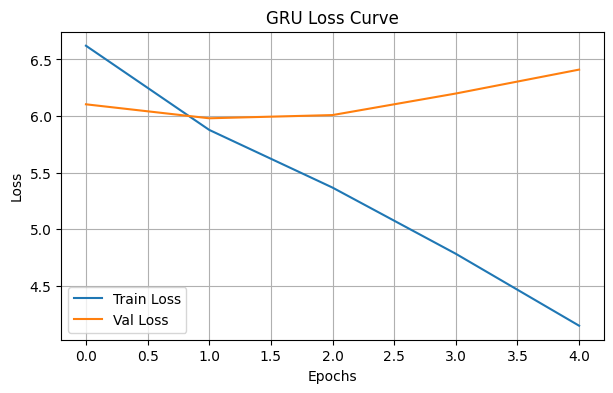

In [ ]:
gru = build_gru(vocab_size, sequence_length)
history_gru = gru.fit(
    X, y,
    validation_split=0.1,
    epochs=5,
    batch_size=64,
    verbose=1
)

train_loss = history_gru.history["loss"][-1]
val_loss = history_gru.history["val_loss"][-1]
perplexity = np.exp(val_loss)
train_acc = history_gru.history["accuracy"][-1]
val_acc = history_gru.history["val_accuracy"][-1]

print("\n===== GRU METRICS =====")
print(f"Train Loss: {train_loss:.4f}")
print(f"Val Loss: {val_loss:.4f}")
print(f"Perplexity: {perplexity:.4f}")
print(f"Train Accuracy: {train_acc:.4f}")
print(f"Val Accuracy: {val_acc:.4f}")

# Loss Curve
plt.figure(figsize=(7,4))
plt.plot(history_gru.history["loss"], label="Train Loss")
plt.plot(history_gru.history["val_loss"], label="Val Loss")
plt.title("GRU Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

**LSTM**

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, 30, 200)           2100400   
                                                                 
 lstm_12 (LSTM)              (None, 256)               467968    
                                                                 
 dense_18 (Dense)            (None, 10502)             2699014   
                                                                 
Total params: 5267382 (20.09 MB)
Trainable params: 5267382 (20.09 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
1457/1457 [==============================] - 42s 28ms/step - loss: 6.6504 - accuracy: 0.0752 - val_loss: 6.1994 - val_accuracy: 0.1174
Epoch 2/5
1457/1457 [==============================] - 36s 25ms/step - loss: 6.0873 - accuracy: 0.0984 - val_loss: 6.0644 - val_accu

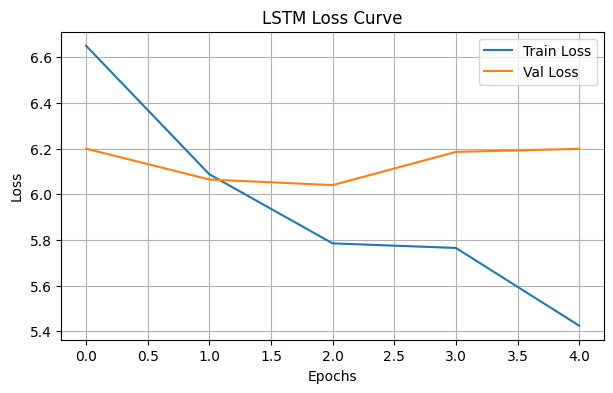

In [ ]:
lstm = build_lstm(vocab_size, sequence_length)
history_lstm = lstm.fit(
    X, y,
    validation_split=0.1,
    epochs=5,
    batch_size=64,
    verbose=1
)

# Metrics
train_loss = history_lstm.history["loss"][-1]
val_loss = history_lstm.history["val_loss"][-1]
perplexity = np.exp(val_loss)
train_acc = history_lstm.history["accuracy"][-1]
val_acc = history_lstm.history["val_accuracy"][-1]

print("\n===== LSTM METRICS =====")
print(f"Train Loss: {train_loss:.4f}")
print(f"Val Loss: {val_loss:.4f}")
print(f"Perplexity: {perplexity:.4f}")
print(f"Train Accuracy: {train_acc:.4f}")
print(f"Val Accuracy: {val_acc:.4f}")

# Loss Curve
plt.figure(figsize=(7,4))
plt.plot(history_lstm.history["loss"], label="Train Loss")
plt.plot(history_lstm.history["val_loss"], label="Val Loss")
plt.title("LSTM Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

 **BiLSTM**

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_19 (Embedding)    (None, 30, 200)           2100400   
                                                                 
 bidirectional_6 (Bidirecti  (None, 512)               935936    
 onal)                                                           
                                                                 
 dense_19 (Dense)            (None, 10502)             5387526   
                                                                 
Total params: 8423862 (32.13 MB)
Trainable params: 8423862 (32.13 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
1457/1457 [==============================] - 76s 51ms/step - loss: 6.6056 - accuracy: 0.0767 - val_loss: 6.1277 - val_accuracy: 0.1158
Epoch 2/5
1457/1457 [==============================] - 68s 47ms/st

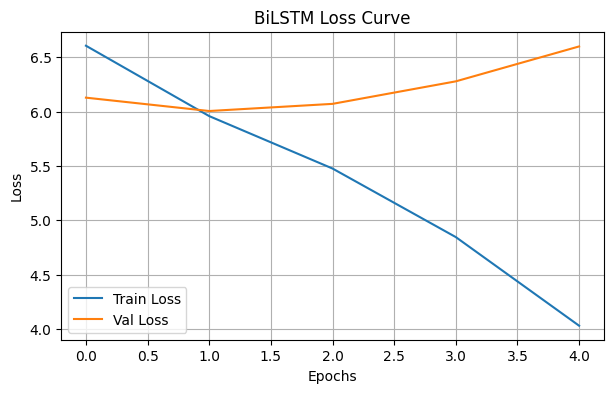

In [ ]:
bilstm = build_bilstm(vocab_size, sequence_length)
history_bilstm = bilstm.fit(
    X, y,
    validation_split=0.1,
    epochs=5,
    batch_size=64,
    verbose=1
)

train_loss = history_bilstm.history["loss"][-1]
val_loss = history_bilstm.history["val_loss"][-1]
perplexity = np.exp(val_loss)
train_acc = history_bilstm.history["accuracy"][-1]
val_acc = history_bilstm.history["val_accuracy"][-1]

print("\n===== BiLSTM METRICS =====")
print(f"Train Loss: {train_loss:.4f}")
print(f"Val Loss: {val_loss:.4f}")
print(f"Perplexity: {perplexity:.4f}")
print(f"Train Accuracy: {train_acc:.4f}")
print(f"Val Accuracy: {val_acc:.4f}")

# Loss Curve
plt.figure(figsize=(7,4))
plt.plot(history_bilstm.history["loss"], label="Train Loss")
plt.plot(history_bilstm.history["val_loss"], label="Val Loss")
plt.title("BiLSTM Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import pandas as pd
import numpy as np

results = []

def add_result(name, history):
    train_loss = history.history['loss'][-1]
    val_loss = history.history['val_loss'][-1]
    perplexity = np.exp(val_loss)
    train_acc = history.history['accuracy'][-1]
    val_acc = history.history['val_accuracy'][-1]
    results.append([name, train_loss, val_loss, perplexity, train_acc, val_acc])

add_result("SimpleRNN", history_simple_rnn)
add_result("GRU", history_gru)
add_result("LSTM", history_lstm)
add_result("BiLSTM", history_bilstm)

df_results = pd.DataFrame(results, columns=[
    "Model", "Train Loss", "Val Loss", "Perplexity", "Train Acc", "Val Acc"
])
df_results


,Model,Train Loss,Val Loss,Perplexity,Train Acc,Val Acc
0,SimpleRNN,6.010469,6.310513,550.326943,0.116586,0.116903
1,GRU,4.145609,6.409818,607.783159,0.215796,0.122116
2,LSTM,5.423971,6.198730,492.123878,0.132387,0.125495
3,BiLSTM,4.029131,6.599041,734.390910,0.223304,0.118255


### **2.3 Text Generation**

In [ ]:
import numpy as np

def generate_text(model, tokenizer, seed_text, num_words=50):
    result = seed_text.split()
    seed = seed_text

    for _ in range(num_words):
        # tokenize and pad
        encoded = tokenizer.texts_to_sequences([seed])[0]
        encoded = encoded[-sequence_length:]  # keep last n words
        encoded = pad_sequences([encoded], maxlen=sequence_length, padding='pre')

        # predict next word
        y_pred = model.predict(encoded, verbose=0)
        next_id = np.argmax(y_pred)

        # get word
        next_word = tokenizer.index_word.get(next_id, "")

        # avoid repeating the last word
        if len(result) > 0 and next_word == result[-1]:
            continue

        if next_word == "":
            continue

        result.append(next_word)
        seed += " " + next_word

    return " ".join(result)

seed = "the ship sailed into the"


generated_text_bilstm = generate_text(bilstm, tokenizer, seed, 60)



print("\n===== BiLSTM Generated Text =====\n")
print(generated_text_bilstm)



===== BiLSTM Generated Text =====

the ship sailed into the cabin gangway to the bottom of the sea it is it that it is a fish of deacon deuteronomy s voice formed a whale ship and a the of the greenland whale s american whale and the pequod s crew will be known to be a long ghost in the sea a the sperm whale fishery i can not know


### **2.4 Embedding Similarity**

In [ ]:
from nltk.tokenize import sent_tokenize, word_tokenize
from gensim.models import Word2Vec

# 1. Sentence tokenize raw text (NOT cleaned text)
raw_sentences = sent_tokenize(raw_text)

# 2. Light tokenization for Word2Vec (no over-cleaning)
processed_sentences = []
for s in raw_sentences:
    tokens = word_tokenize(s.lower())
    tokens = [w for w in tokens if w.isalpha()]
    processed_sentences.append(tokens)

# 3. Train Word2Vec for semantic similarity
w2v_model = Word2Vec(
    processed_sentences,
    vector_size=200,
    window=20,      # bigger context
    min_count=1,    # keep all maritime words
    sg=1,           # skip-gram for better semantics
    workers=4
)

# 4. Find most similar words
similar_words = w2v_model.wv.most_similar("whale", topn=5)
print(similar_words)

[('sperm', 0.9141789674758911), ('white', 0.8695646524429321), ('greenland', 0.8205206394195557), ('english', 0.8034941554069519), ('great', 0.8023857474327087)]


### **2.5 Failure Analysis**

In [ ]:
seed = "the ship sailed into the"

# Generate outputs from weaker models (these fail more reliably)
failure_simple_rnn = generate_text(simple_rnn, tokenizer, seed, num_words=60)
failure_lstm = generate_text(lstm, tokenizer, seed, num_words=60)
failure_gru = generate_text(gru, tokenizer, seed, num_words=60)

# Print all failure samples clearly
print("\n===== FAILURE SAMPLE 1 — SimpleRNN  =====\n")
print(failure_simple_rnn)

print("\n===== FAILURE SAMPLE 2 — LSTM  =====\n")
print(failure_lstm)

print("\n===== FAILURE SAMPLE 3 — GRU =====\n")
print(failure_gru)


===== FAILURE SAMPLE 1 — SimpleRNN  =====

the ship sailed into the ship and the ship wa a

===== FAILURE SAMPLE 2 — LSTM  =====

the ship sailed into the sea and the ship s company and the ship s company and the ship s company and the whale is the whale of the ship and the whale of the sperm whale the whale is the whale of the sperm whale the whale is the whale of the whale the whale is the most of the sea and the whale

===== FAILURE SAMPLE 3 — GRU =====

the ship sailed into the wind and the wind were clearing away the mate and the wind were clearing away the mate and the wind were clearing away the mate and the wind were clearing away the mate and every one of the ship s company were seen gliding by the hardy democracy of the white whale in the propontis in the propontis in the
